<a href="https://colab.research.google.com/github/HammadN98/Pos-Inteligencia-Artificial-e-Computacional/blob/main/Aprendizado-Profundo/ELT575_Semana2_ES119826.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Usando: {device}")

Usando: /GPU:0


In [3]:
#ES119826
#ELT575_Semana2_ES119826

# Importando dados

Aqui usaremos o dataset MNIST (https://en.wikipedia.org/wiki/MNIST_database), que consiste em imagens de dígitos de 0 a 9 escritos manualmente. As imagens desse dataset são na escala grayscale (possuindo um único canal), tendo dimensões 28 x 28 x 1

* Usaremos a versão disponível no tensorflow, mas nada impede que as imagens sejam carregadas de alguma pasta no próprio computador ou carregadas direto para a memória como um array multidimensional (esse último é desaconselhado devido ao volume de dados que serão manipulados durante o treinamento da rede)

# Exemplo

In [4]:
#Exemplo
# carregando dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

## Visualizando uma imagem

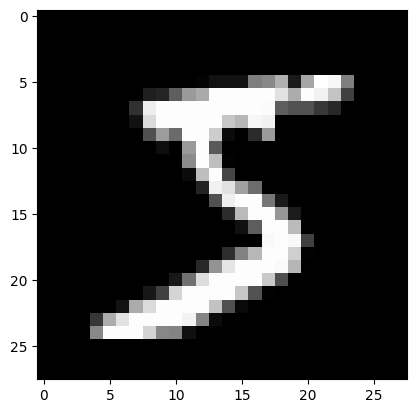

In [5]:
#Exemplo
plt.imshow(trainX[0], cmap='gray');

## Separando os dados

In [6]:
#Exemplo

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [7]:
#Exemplo
# definindo modelo
def define_model_mnist():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

modelo_mnist = define_model_mnist()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9224 - loss: 0.2589 - val_accuracy: 0.9731 - val_loss: 0.0871
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9866 - loss: 0.0427 - val_accuracy: 0.9803 - val_loss: 0.0754
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9922 - loss: 0.0237 - val_accuracy: 0.9808 - val_loss: 0.0742
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9827 - val_loss: 0.0738
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9949 - loss: 0.0147 - val_accuracy: 0.9818 - val_loss: 0.0868
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.9780 - val_loss: 0.1238
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.9819 - val_loss: 0.1127
> 98.267
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9223 - 

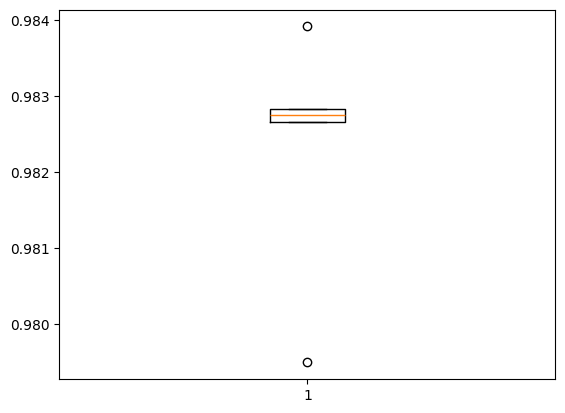

In [9]:
scores_mnist = []
histories_mnist = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model_mnist = define_model_mnist()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history_mnist = model_mnist.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])

  # desempenho do modelo
  _, acc_mnist = model_mnist.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc_mnist * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores_mnist.append(acc_mnist)
  histories_mnist.append(history_mnist)

media_mnist = np.mean(scores_mnist)*100
std_mnist = np.std(scores_mnist)*100
print('Acurácia: média=%.3f desvio=%.3f' % (media_mnist, std_mnist))
plt.boxplot(scores_mnist)
plt.show()

## Testando modelo no conjunto de teste

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


4

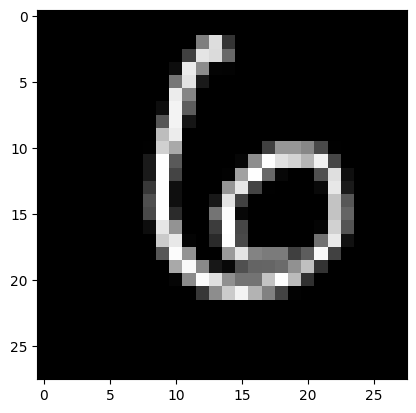

In [10]:
#Exemplo
plt.imshow(testX[100,:,:,0], cmap='gray');
np.argmax(modelo_mnist.predict(np.expand_dims(testX[100], axis=0)))

# Atividade

## Baixando os dados

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [25]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Visualizando a primeira Imagem

A imagem tem classificao de [6] = Sapo


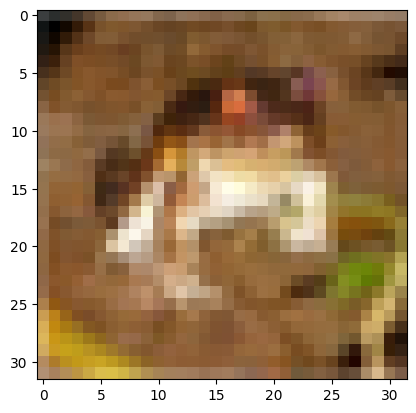

In [13]:
plt.imshow(X_train[0]);
print(f"A imagem tem classificao de {y_train[0]} = Sapo")

## Separando os dado

In [14]:
# fazendo um reshape no dataset para ter um único canal
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3))
X_test = X_test.reshape(( X_test.shape[0], 32, 32, 3))

# Convertendo valores dos pixels em float e normalizando
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') /  255.0


# transformando a variável alvo (target) para uma codificação one hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Definindo o modelo Inicial

In [15]:
# definindo modelo
def define_model_cifar10():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

modelo_cifar = define_model_cifar10()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Funcao para treinar

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
def train(model, epochs:int = 10, batch_size:int = 32, X_train=X_train, y_train=y_train):
  scores = []
  histories = []

  # definindo a validação k-fold
  kfold = KFold(5, shuffle=True, random_state=1)

  # loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
  for train_ix, test_ix in kfold.split(X_train):



    # recorta dados de acordo com índices da k-fold
    train_data, train_target, val_data, val_target = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]

    # treinamento do modelo
    history = model.fit(train_data, train_target,
                    epochs=10, batch_size=32,
                    validation_data=(val_data, val_target),
                    verbose=1, callbacks=[callback])

    # desempenho do modelo
    _, acc = model.evaluate(val_data, val_target, verbose=1)
    print('> %.3f' % (acc * 100.0))

    # armazena resultados de cada modelo treinado dentro da k-fold
    scores.append(acc)
    histories.append(history)
  return scores


## Treino do primeiro modelo

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4587 - loss: 1.5746 - val_accuracy: 0.4640 - val_loss: 1.5510
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6481 - loss: 0.9917 - val_accuracy: 0.5824 - val_loss: 1.2232
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7408 - loss: 0.7449 - val_accuracy: 0.6213 - val_loss: 1.1350
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8077 - loss: 0.5608 - val_accuracy: 0.5401 - val_loss: 1.7346
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8605 - loss: 0.4089 - val_accuracy: 0.5821 - val_loss: 1.6367
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9026 - loss: 0.2851 - val_accuracy: 0.6101 - val_loss: 1.6049
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6232 - loss: 1.1335
> 62.130
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7527 - loss: 0.7401 - val_accuracy: 0.7257 - val_loss: 0.7896
Epoc

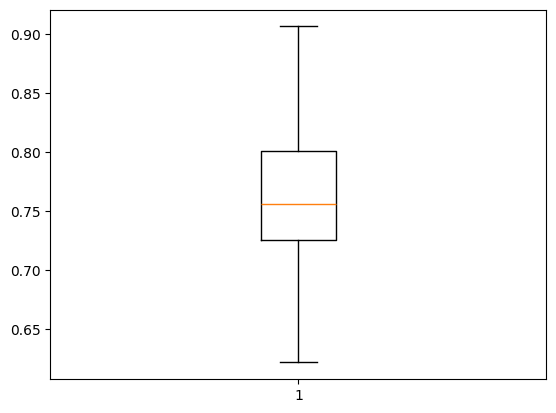

In [17]:
scores_cifar = train(model=modelo_cifar)
media_cifar = np.mean(scores_cifar)*100
std_cifar = np.std(scores_cifar)*100
print(f'Acurácia: média={media_cifar:.3f} desvio={std_cifar:.3f}')
plt.boxplot(scores_cifar)
plt.show()

scores_minst = train(model=modelo_mnist, X_train=trainX, y_train=trainY)
print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores_minst)*100, np.std(scores_minst)*100))
plt.boxplot(scores_minst)
plt.show()

## Prevendo com o modelo treinado

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


5

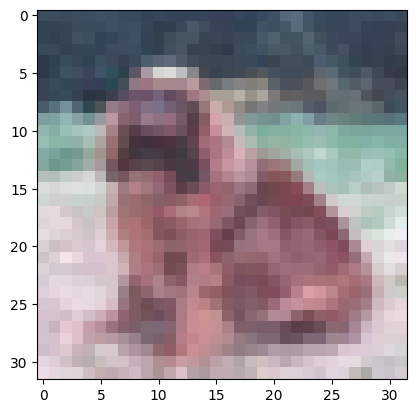

In [18]:
plt.imshow(X_test[101]);
np.argmax(modelo_cifar.predict(np.expand_dims(X_test[101], axis=0)))

# Houve muita diferença no desempenho da rede treinada quando comparado ao exemplo?  

* modelo.mnist:  Acurácia: média=98.233 desvio=0.149
* modelo_cifar10: Acurácia: média=76.222 desvio=9.342

O modelo treinado no exemplo obteve um desempenho significativamente superior ao modelo treinado com CIFAR-10, apresentando uma média de precisão aproximadamente 29% maior e um desvio padrão cerca de 62 vezes menor.

## Experimente adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.

In [19]:
# definindo modelo
def define_model_cifar10_conv2_maxpool():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  ##Exercicio##
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  ##Fim Exercicio##
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_cifar10_conv2_maxpool = define_model_cifar10_conv2_maxpool()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3922 - loss: 1.6462 - val_accuracy: 0.5449 - val_loss: 1.2833
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6047 - loss: 1.1141 - val_accuracy: 0.5858 - val_loss: 1.1583
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6657 - loss: 0.9515 - val_accuracy: 0.5710 - val_loss: 1.3038
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7051 - loss: 0.8430 - val_accuracy: 0.6501 - val_loss: 0.9939
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7367 - loss: 0.7575 - val_accuracy: 0.6669 - val_loss: 1.0053
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7582 - loss: 0.6896 - val_accuracy: 0.6351 - val_loss: 1.0976
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7759 - loss: 0.6368 - val_accuracy: 0.6607 - val_loss: 1.0205
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6543 - loss: 0.9835
> 65.010
Epo

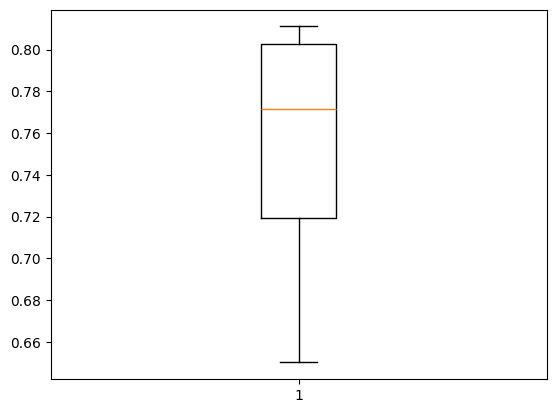

In [20]:
scores_cifar_conv2_maxpool = train(model=model_cifar10_conv2_maxpool)

media_cifar_conv2_maxpool = np.mean(scores_cifar_conv2_maxpool)*100
std_cifar_conv2_maxpool = np.std(scores_cifar_conv2_maxpool)*100

print(f'Acurácia: média={media_cifar_conv2_maxpool:.3f} desvio={std_cifar_conv2_maxpool:.3f}')
plt.boxplot(scores_cifar_conv2_maxpool)
plt.show()

A acuracia media do modelo se manteve no mesmo patamar, um levemente abaixo  com a adicao de dois blocos com camadas Conv2d + maxpooling. Porem o desvio padrao foi diminiudo em certa de 30%, mostrando assim que o modelo esta consistente.

## Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling.

In [21]:
# definindo modelo
def define_model_cifar10_conv2_maxpool_dropout():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  ##Exercicio##
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  ##Fim Exercicio##
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_cifar10_conv2_maxpool_dropout = define_model_cifar10_conv2_maxpool_dropout()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3297 - loss: 1.8152 - val_accuracy: 0.4880 - val_loss: 1.4110
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5166 - loss: 1.3349 - val_accuracy: 0.5169 - val_loss: 1.3842
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5754 - loss: 1.2037 - val_accuracy: 0.5710 - val_loss: 1.2506
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6057 - loss: 1.1145 - val_accuracy: 0.6544 - val_loss: 1.0161
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6290 - loss: 1.0521 - val_accuracy: 0.6207 - val_loss: 1.0780
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6479 - loss: 1.0029 - val_accuracy: 0.6587 - val_loss: 0.9854
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6570 - loss: 0.9671 - val_accuracy: 0.6814 - val_loss: 0.9120
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6713 - loss: 0.934

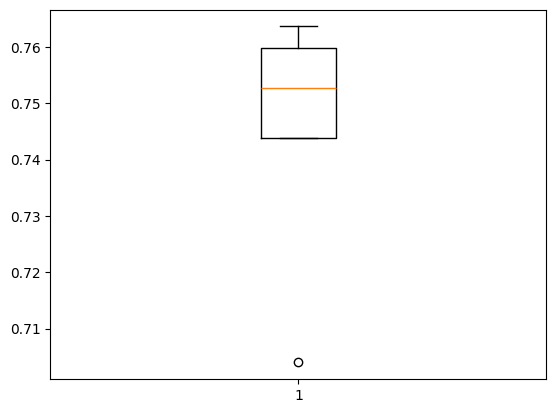

In [22]:
scores_cifar_conv2_maxpool_dropout = train(model=model_cifar10_conv2_maxpool_dropout)

media_cifar_conv2_maxpool_dropout = np.mean(scores_cifar_conv2_maxpool_dropout)*100
std_cifar_conv2_maxpool_dropout = np.std(scores_cifar_conv2_maxpool_dropout)*100

print(f'Acurácia: média={media_cifar_conv2_maxpool_dropout:.3f} desvio={std_cifar_conv2_maxpool_dropout:.3f}')

plt.boxplot(scores_cifar_conv2_maxpool_dropout)
plt.show()

A acuracia deste modelo em compracao com o modelo acima, teve 1% de piora, porem os desvio padrao foi novamente, perto de 65%, se tornando um modelo ainda mais consistente.

##Resultados obtidos

1.Houve muita diferença no desempenho da rede treinada quando comparado ao exemplo?  

* modelo.mnist:  Acurácia: média=98.233 desvio=0.149
* modelo_cifar10: Acurácia: média=76.222 desvio=9.342

- O modelo treinado no exemplo obteve um desempenho significativamente superior ao modelo treinado com CIFAR-10, apresentando uma média de precisão aproximadamente 29% maior e um desvio padrão cerca de 62 vezes menor.

2.Experimente adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.
- R: A acuracia media do modelo se manteve no mesmo patamar, um levemente abaixo  com a adicao de dois blocos com camadas Conv2d + maxpooling. Porem o desvio padrao foi diminiudo em certa de 30%, mostrando assim que o modelo esta consistente.

3.Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling. Comente os resultados obtidos.
- R: A acuracia deste modelo em compracao com o modelo acima, teve 1% de piora, porem os desvio padrao foi novamente, perto de 65%, se tornando um modelo ainda mais consistente.



In [26]:
resultados = [
    {"modelo:": "modelo_exemplo", "media": media_mnist, "std:" : std_mnist},
    {"modelo:": "cifar_base", "media": media_cifar, "std:" : std_cifar},
    {"modelo:": "cifa_conv2_maxpool", "media": media_cifar_conv2_maxpool, "std:" : std_cifar_conv2_maxpool},
    {"modelo:": "cifa_conv2_maxpool_dropout", "media": media_cifar_conv2_maxpool_dropout, "std:" : std_cifar_conv2_maxpool_dropout},
]
import pandas as pd
tabela_resultados = pd.DataFrame(resultados)

In [27]:
tabela_resultados

,modelo:,media,std:
0,modelo_exemplo,98.233333,0.148791
1,cifar_base,76.221999,9.341784
2,cifa_conv2_maxpool,75.104001,5.983817
3,cifa_conv2_maxpool_dropout,74.475999,2.146388
